In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                      
from iminuit import Minuit
from iminuit.cost import LeastSquares
from itertools import accumulate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

In [2]:
t_HLA = np.load('times_HLA.npy')
t_DAZ = np.load('times_DAZ.npy')
t_LWN = np.load('times_LWN.npy')
t_PVX = np.load('times_PVX.npy')

t1 = t_HLA
t2 = (t_DAZ[:-1] + t_DAZ[1:])[::2]
t3 = (t_LWN[:-2] + t_LWN[1:-1] + t_LWN[2:])[::3]
t4 = (t_PVX[:-2] + t_PVX[1:-1] + t_PVX[2:])[::3]


t1_sum = np.cumsum(t1)
t2_sum = np.cumsum(t2)
t3_sum = np.cumsum(t3)
t4_sum = np.cumsum(t4)


t1_mean = np.mean(t1)
t2_mean = np.mean(t2)
t3_mean = np.mean(t3)
t4_mean = np.mean(t4)

t1_std = np.std(t1)
t2_std = np.std(t2)
t3_std = np.std(t3)
t4_std = np.std(t4)

min_valuse = min(len(t1), len(t2), len(t3), len(t4))

all_times = np.zeros((4, min_valuse))
all_times[0, :] = t1[:min_valuse]
all_times[1, :] = t2[:min_valuse]
all_times[2, :] = t3[:min_valuse]
all_times[3, :] = t4[:min_valuse]
times = np.mean(all_times, axis=0)
times_sum = np.cumsum(times)

long_list = np.concatenate((t1,t2,t3,t4))
long_list_sum = np.cumsum(long_list)
np.random.shuffle(long_list)
long_list_scramble_sum = np.cumsum(long_list)



In [3]:
save_plots = False
Minuit.print_level = 0

#Uncertaintees
a = 9.82
b = 0
print(np.std(t1))
sigmay = 0.2


x = np.arange(len(t1_sum))+1
y = np.array(t1_sum) 
sy = sigmay*np.ones_like(x)

def fit_func(x, a, b): 
    return a*x + b

chi2 = LeastSquares(x,y,sy,fit_func)

def chi2_func(a,b):
    return np.sum(((y - fit_func(x,a,b)) / sy)**2)

mfit = Minuit(chi2_func,a=a,b=b)

mfit.migrad();

a_fit = mfit.values['a']
b_fit = mfit.values['b']
sigma_a_fit = mfit.errors['a']
sigma_b_fit = mfit.errors['b']

Nvar = 2                     
Ndof_fit = len(t1) - Nvar

Chi2_fit = mfit.fval                            
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)



print(f"  Fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  p={Prob_fit:6.4f}")



0.19998478090773605
  Fit: a= 9.397+-0.003  b=-0.387+-0.068  p=0.7994


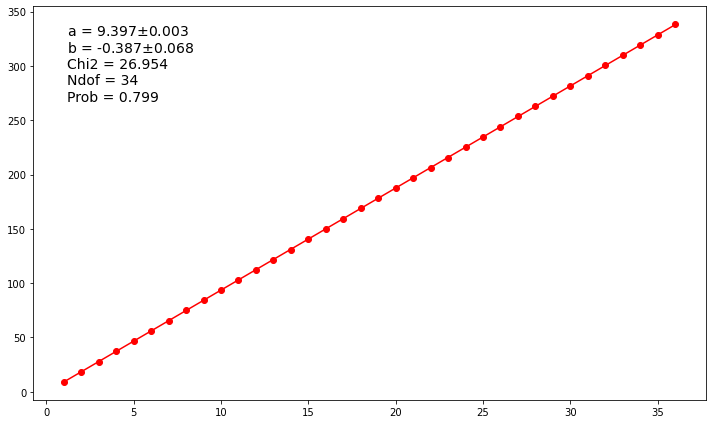

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_func(x, *mfit.values[:]), '-r')

fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]
ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)
fig.tight_layout()


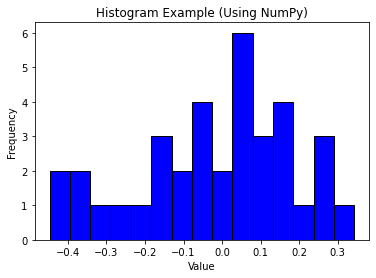

In [5]:
residuals = (a_fit - t1)


counts, bin_edges = np.histogram(residuals, bins=15)

# Plot the histogram
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black')

# Add titles and labels
plt.title('Histogram Example (Using NumPy)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

9.396935036255098
[ 0.14185887  0.07597332  0.19250493 -0.28555889  0.36929398  0.07109742
 -0.13216014 -0.15038008  0.19227796 -0.37727923  0.26926904  0.0567811
  0.11775522  0.10588794 -0.19243402 -0.02570576 -0.09742183 -0.00162287
  0.10331087  0.2200182  -0.13905663  0.01974015  0.00124126 -0.07280488
  0.08258586 -0.42074985 -0.02538485  0.2889102   0.11323719  0.2838512
 -0.34364195 -0.34137101  0.15866094 -0.02899022  0.16186314 -0.2341959 ]
0.004371130274245714


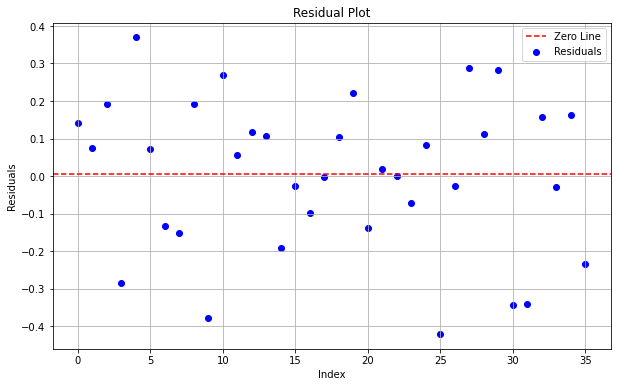

In [6]:
residuals = a_fit - t1
print(a_fit)
print(residuals)
print(np.mean(residuals))

# Create an x-axis based on the indices of long_list
x_res1 = np.arange(len(t1))

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(x_res1, residuals, color='blue', label='Residuals')
plt.axhline(y=np.mean(residuals), color='red', linestyle='--', label='Zero Line')  # Zero reference line

# Labels and title
plt.title("Residual Plot")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

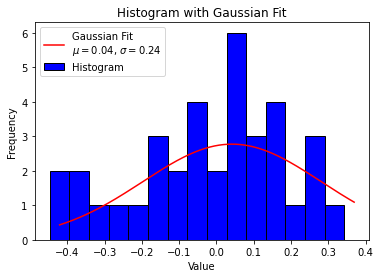

Fitted standard deviation (sigma): 0.24


In [7]:
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1]) 

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

least_squares = LeastSquares(bin_centers, counts, np.sqrt(counts), gaussian)


m = Minuit(least_squares, A=max(counts), mu=np.mean(residuals), sigma=np.std(residuals))
m.migrad()  

A_fit, mu_fit, sigma_fit = m.values["A"], m.values["mu"], m.values["sigma"]

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
y_fit = gaussian(x_fit, A_fit, mu_fit, sigma_fit)

plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='blue', edgecolor='black', label="Histogram")
plt.plot(x_fit, y_fit, color="red", label=f"Gaussian Fit\n$\mu={mu_fit:.2f}$, $\sigma={sigma_fit:.2f}$")
plt.title("Histogram with Gaussian Fit")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Fitted standard deviation (sigma): {sigma_fit:.2f}")


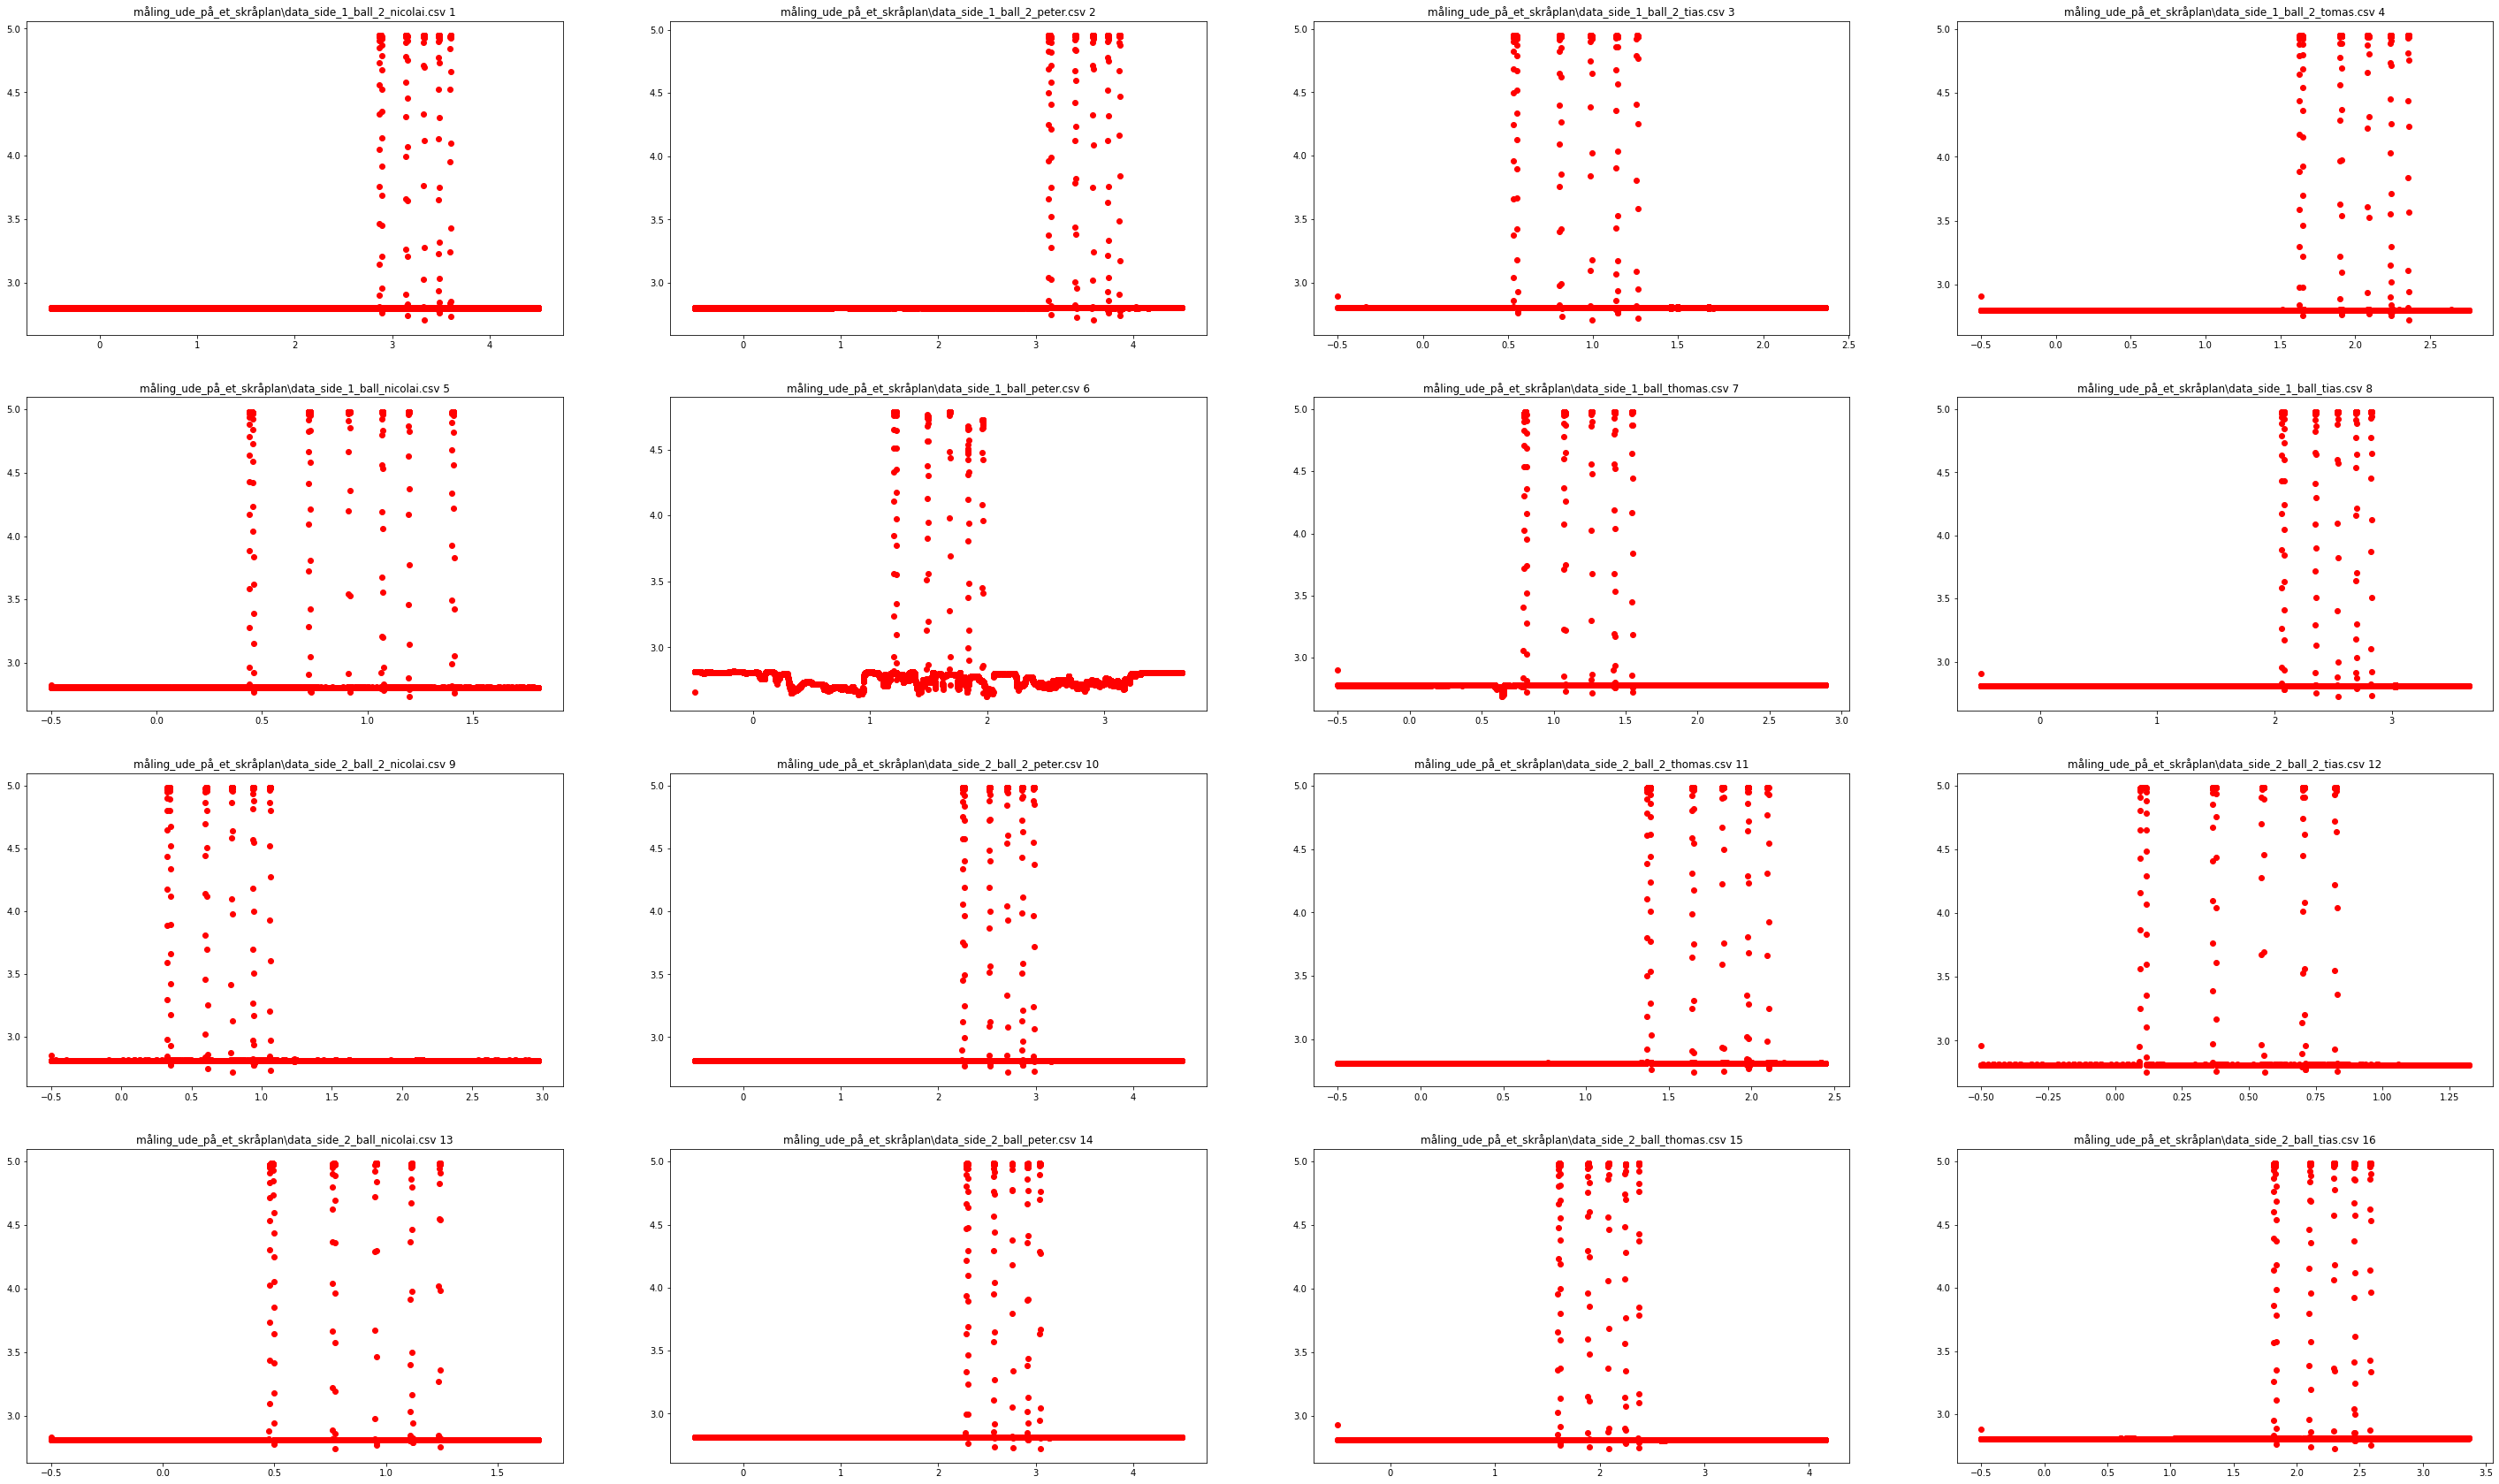

In [8]:
import glob as gb

files = gb.glob('måling_ude_på_et_skråplan/*.csv')


data_points  = []
for i, file in enumerate(files):
   data_points.append(np.genfromtxt(file, delimiter=',', skip_header=15, usecols=(0,1)))
   



fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(data_points[i][:,0], data_points[i][:,1], 'ro')
    ax.set_title(f'{files[i]} {i+1}')


In [9]:
sensor_afstand_1 = np.array([18.6,36.4,54.5,73.6,91.2]) / 100
sensor_afstand_2 = np.array([18.7,36.3,54.6,73.5,91.2]) / 100
sensor_afstand_3 = np.array([18.7,36.4,54.6,73.55,91.65]) / 100
sensor_afstand_4 = np.array([18.4,36.4,54.5,73.5,91.2]) / 100
samlet_afstand = (sensor_afstand_1 + sensor_afstand_2 + sensor_afstand_3 + sensor_afstand_4) / 4 

d_r_inder = 0.006 
bold_1 = 0.01
bold_2 = 0.0125
vinkel_v = (76.1 + 76.5 + 76.1 + 76.2) / 4
vinkel_h = (76 + 76.3 + 75.95 + 75.9) / 4 
vinkel_v1 = (76.4 + 76.5 + 76.2 + 76.3) / 4
vinkel_h1 = (75.9 + 76.5 + 76 + 76) / 4
samlet_vinkel = (vinkel_v + vinkel_h + vinkel_v1 + vinkel_h1) / 4



IndexError: arrays used as indices must be of integer (or boolean) type

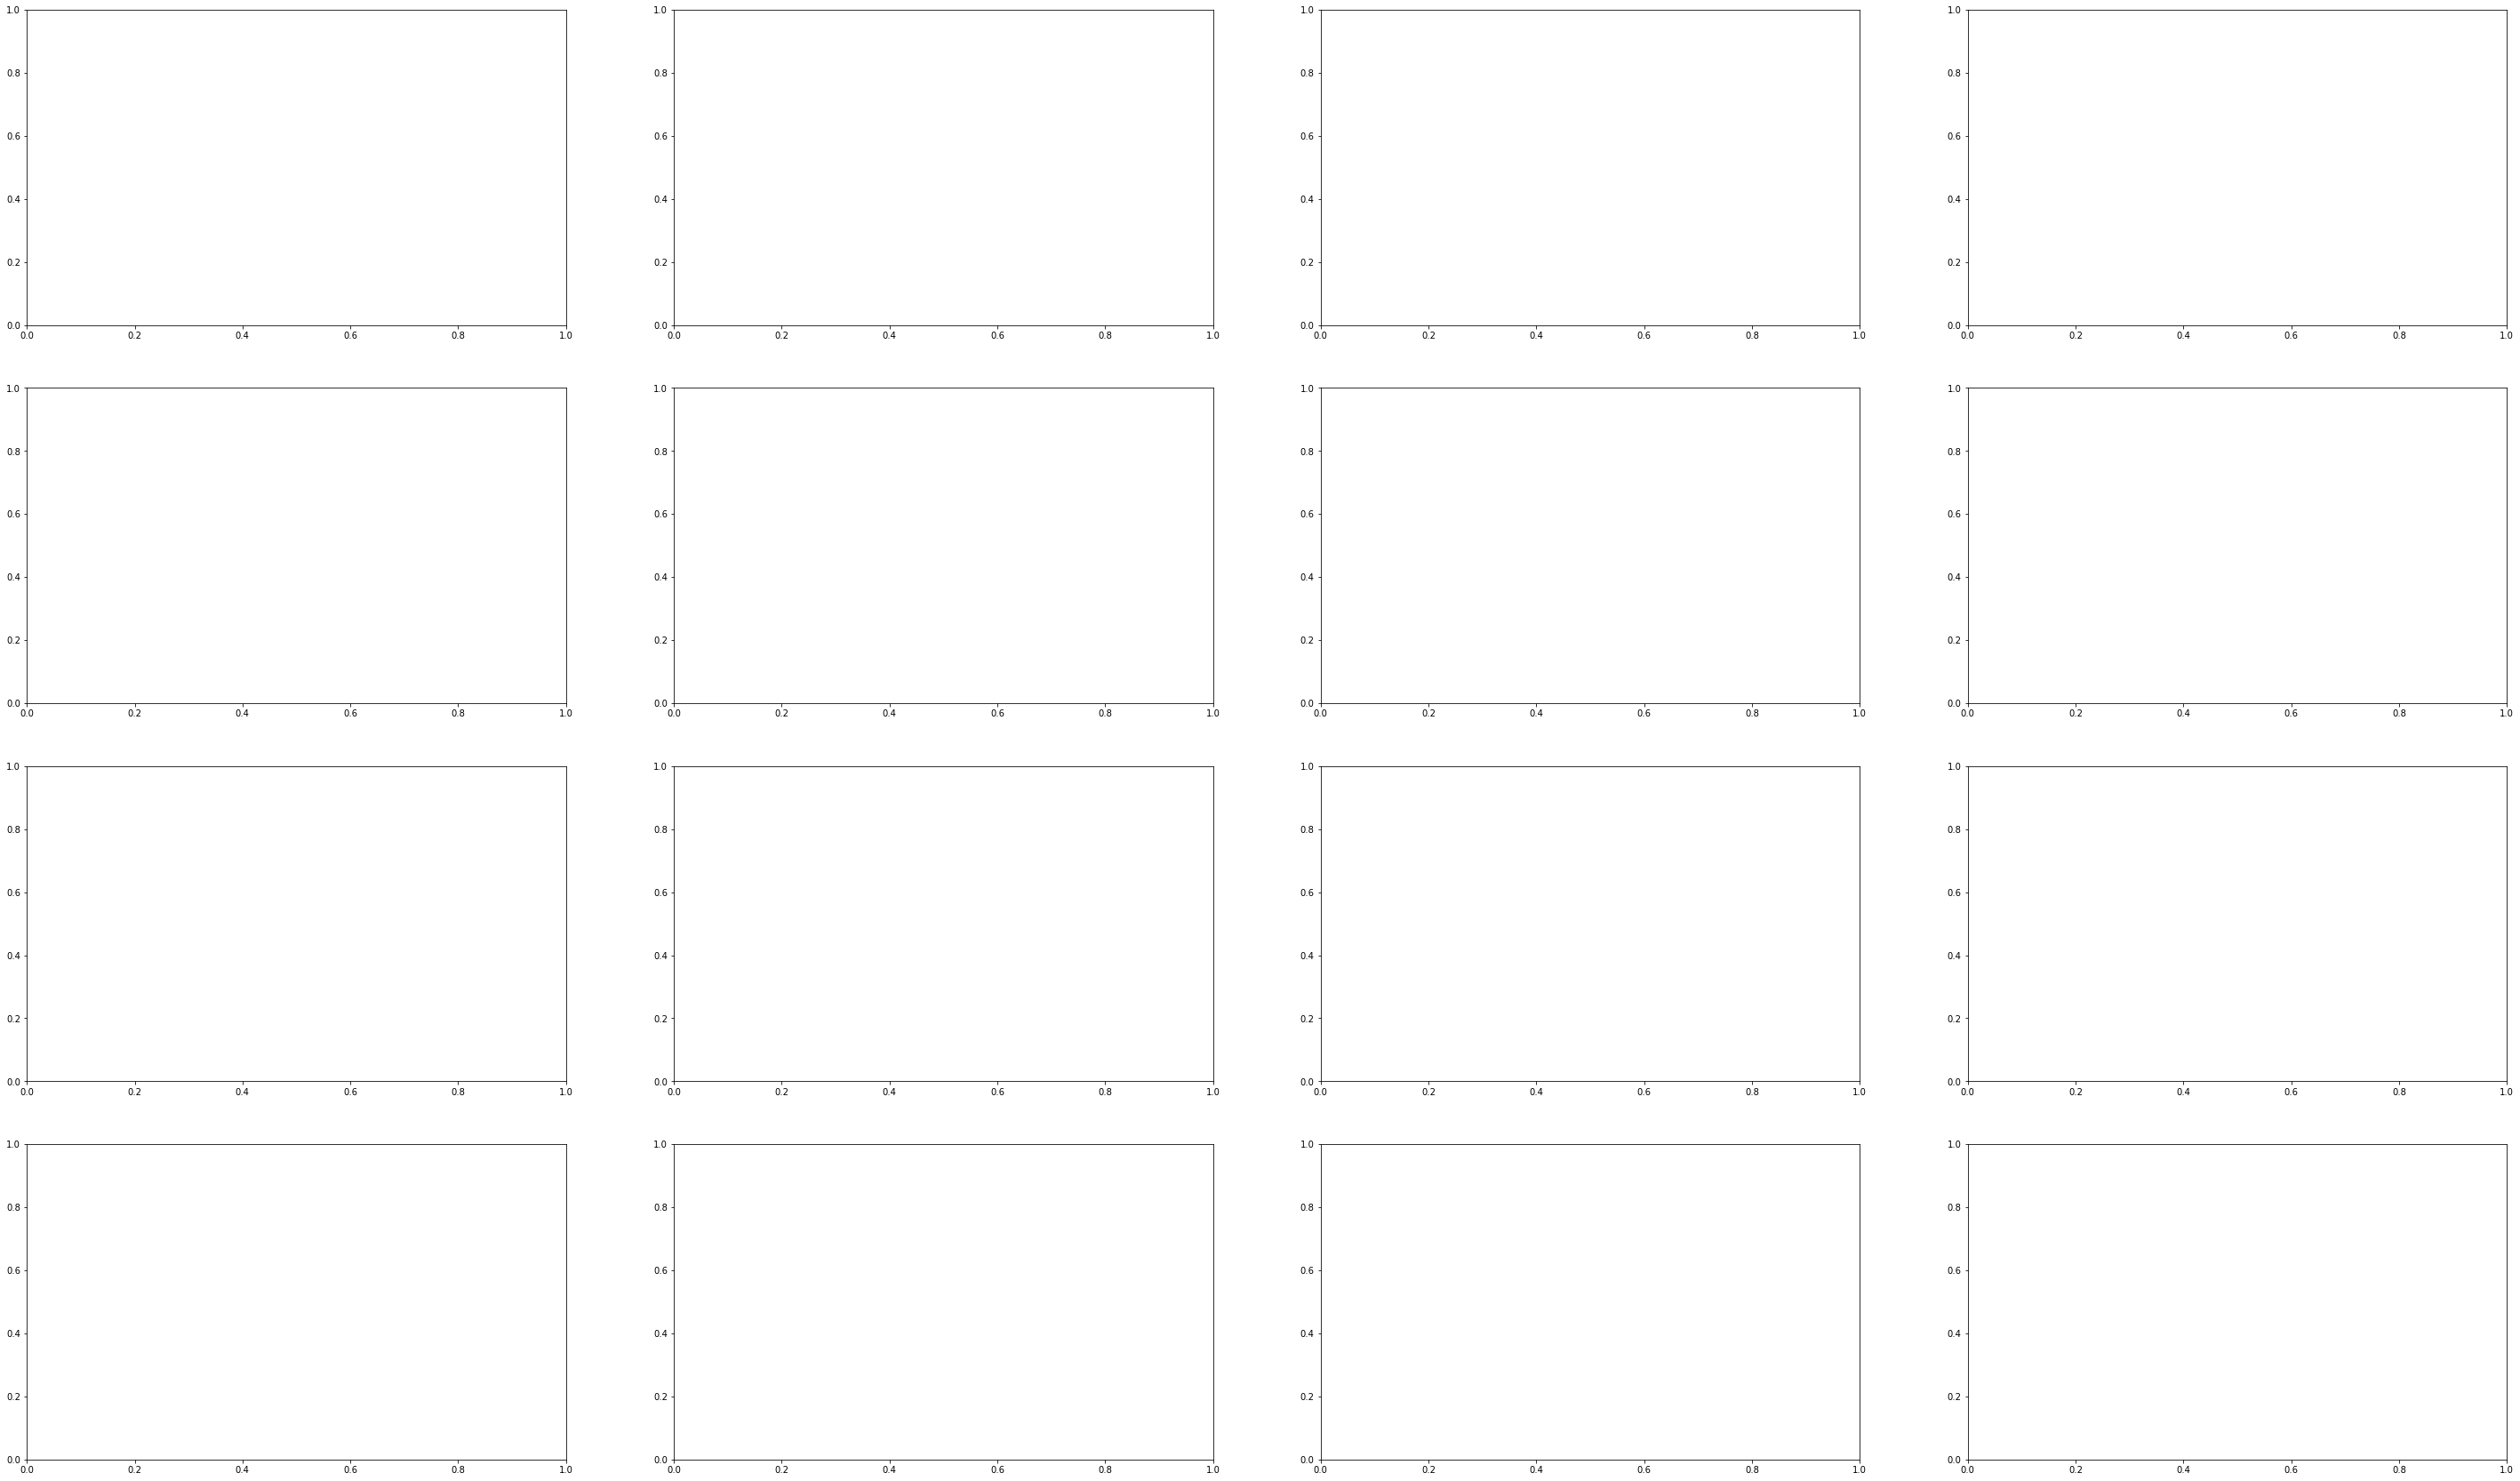

In [11]:
fig, axs = plt.subplots(4,4,figsize=(50,30))
axs = axs.flatten()
bold_weight= []
for i in files:
    bold_weight.append(bold_1 if '1_ball' in i else bold_2)
bold_weight = np.array(bold_weight)


final_a = np.zeros(16)


ax = axs[data_points[0]]
data_peaks = data[data[:,1] > 4.5]

time_start = data_peaks[(np.abs(np.roll(data_peaks,1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]
time_stop =data_peaks[(np.abs(np.roll(data_peaks,-1,axis=0)-data_peaks)[:,0]) > 0.01][:,0]

t  =  (time_start + (time_stop - time_start)/2 - time_start[0])[:5]
    
 

a, b, c = 9.82, 0, 0
sigmay = np.std(time_start- time_stop)

x = np.array(t)

y = samlet_afstand
sy = sigmay * np.ones_like(x)

def fit_func(x, a, b, c): 
    return a*x**2 + b*x + c

chi2 = LeastSquares(x,y,sy,fit_func)

def chi2_func( a, b, c):
    return np.sum(((y - fit_func(x, a, b, c)) / sy)**2)

mfit = Minuit(chi2_func,a=a,b=b, c=c)

mfit.migrad()

a_fit = mfit.values['a']
b_fit = mfit.values['b']
c_fit = mfit.values['c']
sigma_c_fit = mfit.errors['c']
sigma_a_fit = mfit.errors['a']
sigma_b_fit = mfit.errors['b']
final_a[i] = a_fit
Nvar = 3                   
Ndof_fit = len(t) - Nvar

Chi2_fit = mfit.fval                            
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)
    
print(f"fit: a={a_fit:6.3f}+-{sigma_a_fit:5.3f}  b={b_fit:5.3f}+-{sigma_b_fit:5.3f}  c={c_fit:5.3f}+-{sigma_c_fit:5.3f}  p={Prob_fit:6.4f}")
ax.errorbar(x, y, sy, fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
ax.plot(x, fit_func(x, *mfit.values[:]), '-r')      

fit_info = [f'a = {a_fit:5.3f}' + r'$\pm$' +  f"{sigma_a_fit:5.3f}",
            f'b = {b_fit:5.3f}' + r'$\pm$' + f"{sigma_b_fit:5.3f}",
            f'c = {c_fit:5.3f}' + r'$\pm$' + f"{sigma_c_fit:5.3f}",
            f'Chi2 = {Chi2_fit:5.3f}',
            f'Ndof = {Ndof_fit:d}',
            f'Prob = {Prob_fit:5.3f}',
]

ax.text(0.05, 0.76, "\n".join(fit_info), fontsize=14, transform = ax.transAxes)



In [ ]:
rail_tyk = (3 + 2.9 + 3 + 3) / 400 

#regnet vinkel 
a = (22.2 + 22+ 22.2 + 22.3 - 4*rail_tyk) / 400
c = (93.45 + 93.65 + 93.5 + 93.6) / 400
b = np.sqrt(c**2 - a**2)
print(b)

theta2 = np.arcsin(b / c)
print(theta2*180 / np.pi)

In [ ]:
a_1 = final_a *2
theta = np.deg2rad(90-samlet_vinkel)
g = (a_1 / np.sin(theta)) * (1+(2/5)*(bold_weight**2) / (bold_weight**2 - d_r_inder**2))
print(a_1)

